In [ ]:
from fastai.text import *

In [ ]:
path = Config().data_path()/'giga-fren'
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/giga-fren/small_qrnn_vocab.pkl'),
 PosixPath('/home/ubuntu/.fastai/data/giga-fren/en2fr'),
 PosixPath('/home/ubuntu/.fastai/data/giga-fren/cc.en.300.bin'),
 PosixPath('/home/ubuntu/.fastai/data/giga-fren/small_qrnn.pth'),
 PosixPath('/home/ubuntu/.fastai/data/giga-fren/data_save.pkl'),
 PosixPath('/home/ubuntu/.fastai/data/giga-fren/models'),
 PosixPath('/home/ubuntu/.fastai/data/giga-fren/questions_easy.csv'),
 PosixPath('/home/ubuntu/.fastai/data/giga-fren/giga-fren.release2.fixed.en'),
 PosixPath('/home/ubuntu/.fastai/data/giga-fren/questions.csv'),
 PosixPath('/home/ubuntu/.fastai/data/giga-fren/giga-fren.release2.fixed.fr'),
 PosixPath('/home/ubuntu/.fastai/data/giga-fren/cc.fr.300.bin')]

## Load data

We reuse the same functions as in the translation notebook to load our data.

In [ ]:
def seq2seq_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0]):],res_y[i,:len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x, res_y

In [ ]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [ ]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

Refer to the translation notebook for creation of 'questions_easy.csv'.

In [ ]:
df = pd.read_csv(path/'questions_easy.csv')

In [ ]:
src = Seq2SeqTextList.from_df(df, path = path, cols='fr').split_by_rand_pct().label_from_df(cols='en', label_cls=TextList)

In [ ]:
np.percentile([len(o) for o in src.train.x.items] + [len(o) for o in src.valid.x.items], 90)

29.0

In [ ]:
np.percentile([len(o) for o in src.train.y.items] + [len(o) for o in src.valid.y.items], 90)

26.0

As before, we remove questions with more than 30 tokens.

In [ ]:
src = src.filter_by_func(lambda x,y: len(x) > 30 or len(y) > 30)

In [ ]:
len(src.train) + len(src.valid)

47389

In [ ]:
data = src.databunch()

In [ ]:
data.save()

Can load from here when restarting.

In [ ]:
data = load_data(path)

In [ ]:
data.show_batch()

text,target
"xxbos xxmaj quand les gens de la xxunk xxunk ont voulu continuer la tradition des concerts et des [ activités ] xxunk , qu’est - ce qu’ils ont fait ?","xxbos xxmaj when the theatre group wanted to continue the tradition of concerts and xxunk ( events ) , what did they do ?"
"xxbos xxmaj quel sera le sort réservé aux suppléments en vertu du projet de loi xxup c-51 , et le dosage fera - t - il l'objet d'une réglementation ?",xxbos xxmaj what is the future under xxmaj bill xxup c-51 for supplements and will there be regulated doses ?
"xxbos xxmaj quelle est la pression moyenne au niveau de la mer selon l'atmosphère - type de xxunk , pour chacune des 3 unités de mesure de la pression ?","xxbos xxmaj what is mean sea level pressure according to the xxup xxunk standard atmosphere , for each of the three standard pressure measurements ?"
"xxbos xxmaj quelles initiatives le xxmaj gouvernement a - t - il prises pour accroître la présence des femmes dans la fonction publique , notamment aux postes de responsabilité ?","xxbos xxmaj which initiatives has the xxmaj government taken to increase women ’s presence in the civil service , particularly in high - ranking positions ?"
xxbos xxmaj de quelles données dispose - t - on sur l’impact des changements en matière de mécanismes de paiement ou de mesures incitatives sur l’utilisation et les coûts ?,xxbos xxmaj what is the evidence on the impact of changes in payment mechanisms or incentives on utilization and costs ?


## Transformer model

![Transformer model](images/Transformer.png)

### Shifting

We add a transform to the dataloader that shifts the targets right and adds a padding at the beginning.

In [ ]:
def shift_tfm(b):
    x,y = b
    y = F.pad(y, (1, 0), value=1)
    return [x,y[:,:-1]], y[:,1:]

In [ ]:
data.add_tfm(shift_tfm)

### Embeddings

The input and output embeddings are traditional PyTorch embeddings (and we can use pretrained vectors if we want to). The transformer model isn't a recurrent one, so it has no idea of the relative positions of the words. To help it with that, they had to the input embeddings a positional encoding which is cosine of a certain frequency:

In [ ]:
class PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d:int):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
    
    def forward(self, pos:Tensor):
        inp = torch.ger(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

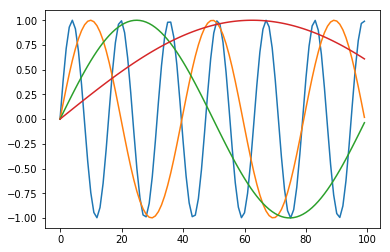

In [ ]:
tst_encoding = PositionalEncoding(20)
res = tst_encoding(torch.arange(0,100).float())
_, ax = plt.subplots(1,1)
for i in range(1,5): ax.plot(res[:,i])

In [ ]:
class TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, vocab_sz:int, emb_sz:int, inp_p:float=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = embedding(vocab_sz, emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
    
    def forward(self, inp): 
        pos = torch.arange(0, inp.size(1), device=inp.device).float()
        return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

### Feed forward

The feed forward cell is easy: it's just two linear layers with a skip connection and a LayerNorm.

In [ ]:
def feed_forward(d_model:int, d_ff:int, ff_p:float=0., double_drop:bool=True):
    layers = [nn.Linear(d_model, d_ff), nn.ReLU()]
    if double_drop: layers.append(nn.Dropout(ff_p))
    return SequentialEx(*layers, nn.Linear(d_ff, d_model), nn.Dropout(ff_p), MergeLayer(), nn.LayerNorm(d_model))

### Multi-head attention

![Multi head attention](images/attention.png)

In [ ]:
class MultiHeadAttention(nn.Module):
    "MutiHeadAttention."
    
    def __init__(self, n_heads:int, d_model:int, d_head:int=None, resid_p:float=0., attn_p:float=0., bias:bool=True,
                 scale:bool=True):
        super().__init__()
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads,self.d_head,self.scale = n_heads,d_head,scale
        self.q_wgt = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.k_wgt = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.v_wgt = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att,self.drop_res = nn.Dropout(attn_p),nn.Dropout(resid_p)
        self.ln = nn.LayerNorm(d_model)
        
    def forward(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None):
        return self.ln(q + self.drop_res(self.out(self._apply_attention(q, k, v, mask=mask))))
    
    def _apply_attention(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None):
        bs,seq_len = q.size(0),q.size(1)
        wq,wk,wv = self.q_wgt(q),self.k_wgt(k),self.v_wgt(v)
        wq,wk,wv = map(lambda x:x.view(bs, x.size(1), self.n_heads, self.d_head), (wq,wk,wv))
        wq,wk,wv = wq.permute(0, 2, 1, 3),wk.permute(0, 2, 3, 1),wv.permute(0, 2, 1, 3)
        attn_score = torch.matmul(wq, wk)
        if self.scale: attn_score = attn_score.div_(self.d_head ** 0.5)
        if mask is not None: 
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
        attn_vec = torch.matmul(attn_prob, wv)
        return attn_vec.permute(0, 2, 1, 3).contiguous().contiguous().view(bs, seq_len, -1)
        
    def _attention_einsum(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None):
        # Permute and matmul is a little bit faster but this implementation is more readable
        bs,seq_len = q.size(0),q.size(1)
        wq,wk,wv = self.q_wgt(q),self.k_wgt(k),self.v_wgt(v)
        wq,wk,wv = map(lambda x:x.view(bs, x.size(1), self.n_heads, self.d_head), (wq,wk,wv))
        attn_score = torch.einsum('bind,bjnd->bijn', (wq, wk))
        if self.scale: attn_score = attn_score.mul_(1/(self.d_head ** 0.5))
        if mask is not None: 
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=2))
        attn_vec = torch.einsum('bijn,bjnd->bind', (attn_prob, wv))
        return attn_vec.contiguous().view(bs, seq_len, -1)

### Masking

The attention layer uses a mask to avoid paying attention to certain timesteps. The first thing is that we don't really want the network to pay attention to the padding, so we're going to mask it. The second thing is that since this model isn't recurrent, we need to mask (in the output) all the tokens we're not supposed to see yet (otherwise it would be cheating).

In [ ]:
def get_padding_mask(inp, pad_idx:int=1):
    return None
    return (inp == pad_idx)[:,None,:,None]

In [ ]:
def get_output_mask(inp, pad_idx:int=1):
    return torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None].byte()
    return ((inp == pad_idx)[:,None,:,None].long() + torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None] != 0)

Example of mask for the future tokens:

In [ ]:
torch.triu(torch.ones(10,10), diagonal=1).byte()

tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.uint8)

### Encoder and decoder blocks

We are now ready to regroup these layers in the blocks we add in the model picture:

![Transformer model](images/Transformer.png)

In [ ]:
class EncoderBlock(nn.Module):
    "Encoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads:int, d_model:int, d_head:int, d_inner:int, resid_p:float=0., attn_p:float=0., ff_p:float=0.,
                 bias:bool=True, scale:bool=True, double_drop:bool=True):
        super().__init__()
        self.mha = MultiHeadAttention(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        self.ff  = feed_forward(d_model, d_inner, ff_p=ff_p, double_drop=double_drop)
    
    def forward(self, x:Tensor, mask:Tensor=None): return self.ff(self.mha(x, x, x, mask=mask))

In [ ]:
class DecoderBlock(nn.Module):
    "Decoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads:int, d_model:int, d_head:int, d_inner:int, resid_p:float=0., attn_p:float=0., ff_p:float=0.,
                 bias:bool=True, scale:bool=True, double_drop:bool=True):
        super().__init__()
        self.mha1 = MultiHeadAttention(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        self.mha2 = MultiHeadAttention(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=ff_p, double_drop=double_drop)
    
    def forward(self, x:Tensor, enc:Tensor, mask_in:Tensor=None, mask_out:Tensor=None): 
        y = self.mha1(x, x, x, mask_out)
        return self.ff(self.mha2(y, enc, enc, mask=mask_in))

### The whole model

In [ ]:
class Transformer(nn.Module):
    "Transformer model"
    
    def __init__(self, inp_vsz:int, out_vsz:int, n_layers:int=6, n_heads:int=8, d_model:int=256, d_head:int=32, 
                 d_inner:int=1024, inp_p:float=0.1, resid_p:float=0.1, attn_p:float=0.1, ff_p:float=0.1, bias:bool=True, 
                 scale:bool=True, double_drop:bool=True, pad_idx:int=1):
        super().__init__()
        self.enc_emb = TransformerEmbedding(inp_vsz, d_model, inp_p)
        self.dec_emb = TransformerEmbedding(out_vsz, d_model, 0.)
        self.encoder = nn.ModuleList([EncoderBlock(n_heads, d_model, d_head, d_inner, resid_p, attn_p, 
                                                   ff_p, bias, scale, double_drop) for _ in range(n_layers)])
        self.decoder = nn.ModuleList([DecoderBlock(n_heads, d_model, d_head, d_inner, resid_p, attn_p, 
                                                   ff_p, bias, scale, double_drop) for _ in range(n_layers)])
        self.out = nn.Linear(d_model, out_vsz)
        self.out.weight = self.dec_emb.embed.weight
        self.pad_idx = pad_idx
        
    def forward(self, inp, out):
        mask_in  = get_padding_mask(inp, self.pad_idx)
        mask_out = get_output_mask (out, self.pad_idx)
        enc,out = self.enc_emb(inp),self.dec_emb(out)
        for enc_block in self.encoder: enc = enc_block(enc, mask_in)
        for dec_block in self.decoder: out = dec_block(out, enc, mask_in, mask_out)
        return self.out(out)

#### Bleu metric (see dedicated notebook)

In [ ]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

In [ ]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [ ]:
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

In [ ]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

### Training

In [ ]:
model = Transformer(len(data.train_ds.x.vocab.itos), len(data.train_ds.y.vocab.itos), d_model=256)

In [ ]:
learn = Learner(data, model, metrics=[accuracy, CorpusBLEU(len(data.train_ds.y.vocab.itos))], 
                loss_func = CrossEntropyFlat())

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


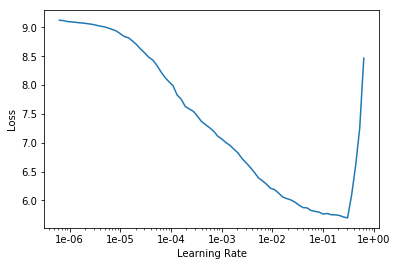

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8, 5e-4, div_factor=5)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,2.424691,2.441312,0.624893,0.465699,01:39
1,1.946387,1.965733,0.689453,0.513099,01:37
2,1.570588,1.628320,0.728240,0.547851,01:38
3,1.315216,1.437255,0.753234,0.577680,01:38
4,1.128669,1.331126,0.765776,0.591145,01:39
5,0.945706,1.277736,0.776960,0.607566,01:39
6,0.865501,1.265128,0.781391,0.613642,01:39
7,0.759556,1.268143,0.781420,0.614102,01:40


In [ ]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(*xb)
            for x,y,z in zip(xb[0],xb[1],out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [ ]:
inputs, targets, outputs = get_predictions(learn)

In [ ]:
inputs[10],targets[10],outputs[10]

(Text xxbos xxmaj pendant que xxunk les activités requises pour maintenir mon xxunk physique , est - ce que je xxunk de la protection d’un régime d’assurance ou de pension ?,
 Text xxbos xxmaj while i go about maintaining this high degree of fitness , am i protected under an insurance or pension plan ?,
 Text xxbos xxmaj while i do to the my physical physical of physical , do i aware by the pension plan service plan ?)

In [ ]:
inputs[700],targets[700],outputs[700]

(Text xxbos xxmaj quelles sont les conséquences sur la recherche , la mise en pratique et les politiques en ce qui a trait à l'ac ?,
 Text xxbos xxmaj what are the xxunk for xxup kt research , practice / policy ?,
 Text xxbos xxmaj what are the implications implications research kt , , policy and policies in)

In [ ]:
inputs[701],targets[701],outputs[701]

(Text xxbos xxmaj quelle est la position des xxmaj états - xxmaj unis , du xxmaj canada et de la xxup xxunk à ce propos ?,
 Text xxbos xxmaj where do the xxup us , xxmaj canada and xxup xxunk stand ?,
 Text xxbos xxmaj what is xxmaj xxup us xxmaj xxmaj united and the xxunk fit in)

In [ ]:
inputs[2500],targets[2500],outputs[2500]

(Text xxbos xxmaj quels sont les atouts particuliers du xxmaj canada en recherche sur l'obésité sur la scène internationale ?,
 Text xxbos xxmaj what are the unique xxmaj canadian strengths in obesity research that set xxmaj canada apart on an international front ?,
 Text xxbos xxmaj what are xxmaj specific strengths canada strengths in obesity - ? are up canada ? from international international stage ?)

In [ ]:
inputs[4002],targets[4002],outputs[4002]

(Text xxbos xxmaj quelles sont les répercussions politiques à long terme de cette révolution scientifique mondiale ?,
 Text xxbos xxmaj what are some of the long - term policy implications of this global knowledge revolution ?,
 Text xxbos xxmaj what are the long the long - term policies implications of this global scientific ? ?)

### Label smoothing

They point out in the paper that using label smoothing helped getting a better BLEU/accuracy, even if it made the loss worse.

In [ ]:
model = Transformer(len(data.train_ds.x.vocab.itos), len(data.train_ds.y.vocab.itos), d_model=256)

In [ ]:
learn = Learner(data, model, metrics=[accuracy, CorpusBLEU(len(data.train_ds.y.vocab.itos))], 
                loss_func=FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1))

In [ ]:
learn.fit_one_cycle(8, 5e-4, div_factor=5)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,3.286583,3.337563,0.626293,0.466046,01:39
1,2.856837,2.906884,0.694047,0.514823,01:40
2,2.625284,2.651707,0.729707,0.548521,01:41
3,2.376412,2.497148,0.751749,0.574652,01:41
4,2.233748,2.400608,0.768083,0.594859,01:41
5,2.103394,2.357367,0.776458,0.604416,01:41
6,2.009131,2.348385,0.781096,0.612397,01:40
7,1.913152,2.349686,0.781749,0.612880,01:41


In [ ]:
learn.fit_one_cycle(8, 5e-4, div_factor=5)

In [ ]:
print("Quels sont les atouts particuliers du Canada en recherche sur l'obésité sur la scène internationale ?")
print("What are Specific strengths canada strengths in obesity - ? are up canada ? from international international stage ?")
print("Quelles sont les répercussions politiques à long terme de cette révolution scientifique mondiale ?")
print("What are the long the long - term policies implications of this global scientific ? ?")

Quels sont les atouts particuliers du Canada en recherche sur l'obésité sur la scène internationale ?
What are Specific strengths canada strengths in obesity - ? are up canada ? from international international stage ?
Quelles sont les répercussions politiques à long terme de cette révolution scientifique mondiale ?
What are the long the long - term policies implications of this global scientific ? ?


In [ ]:
inputs[10],targets[10],outputs[10]

(Text xxbos xxmaj quelle distance y a - t - il entre le point le plus rapproché de la surface à xxunk et la position d’utilisation habituelle du tube radiogène ?,
 Text xxbos xxmaj what is the distance between the nearest point of the area to be shielded and the usual operational position of the x - ray tube ?,
 Text xxbos xxmaj what is the xxmaj between the xxmaj and of the xxmaj ? the ? and the most ? ? of the xxmaj - ray tube ?)

In [ ]:
inputs[700],targets[700],outputs[700]

(Text xxbos xxmaj quels types de présentations xxmaj santé xxmaj canada xxunk - t - il dans le format ectd à compter du 1er septembre ?,
 Text xxbos xxmaj what kind of submission types will xxmaj health xxmaj canada accept on xxmaj september 1 , 2004 in ectd format ?,
 Text xxbos xxmaj what is of information is of be canadian xxmaj canada take ? the canadian ? , and ? the format ?)

In [ ]:
inputs[701],targets[701],outputs[701]

(Text xxbos xxmaj quelles sont les trois caractéristiques qui vous incitent le plus à investir dans votre région ( xxup nommez - xxup les ) ?,
 Text xxbos xxmaj what are the three most attractive features about investing in your region ( xxup name xxup it ) ?,
 Text xxbos xxmaj what is the main main important concerns of the in the country ? xxup xxunk , xxunk ) ?)

In [ ]:
inputs[4001],targets[4001],outputs[4001]

(Text xxbos xxmaj quelles actions avez - vous prises et quel en a été le résultat ?,
 Text xxbos xxmaj what were your actions and the outcomes ?,
 Text xxbos xxmaj what is the targets ? how main of)

### Test leakage

If we change a token in the targets at position n, it shouldn't impact the predictions before that.

In [ ]:
learn.model.eval();

In [ ]:
xb,yb = data.one_batch(cpu=False)

In [ ]:
inp1,out1 = xb[0][:1],xb[1][:1]
inp2,out2 = inp1.clone(),out1.clone()
out2[0,15] = 10

In [ ]:
y1 = learn.model(inp1, out1)
y2 = learn.model(inp2, out2)

In [ ]:
(y1[0,:15] - y2[0,:15]).abs().mean()

tensor(0., device='cuda:0', grad_fn=<MeanBackward1>)